In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_path = 'dataset/oct/retinal_scan/train/'
val_path = 'dataset/oct/retinal_scan/val/'
test_path = 'dataset/oct/retinal_scan/test/'

In [3]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    rotation_range=20
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale= 1./255
)

In [4]:
train_data = train_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    shuffle=True,
    class_mode='categorical',
    batch_size=32
)
val_data = val_datagen.flow_from_directory(
    val_path,
    target_size=(224,224),
    shuffle=False,
    class_mode='categorical',
    batch_size=32
)
test_data = test_datagen.flow_from_directory(
    test_path,
    target_size=(224,224),
    shuffle=False,
    class_mode='categorical',
    batch_size=32
)

Found 18400 images belonging to 8 classes.
Found 2800 images belonging to 8 classes.
Found 2800 images belonging to 8 classes.


In [5]:
import os
Labels = os.listdir(test_path)
Labels

['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'NORMAL']

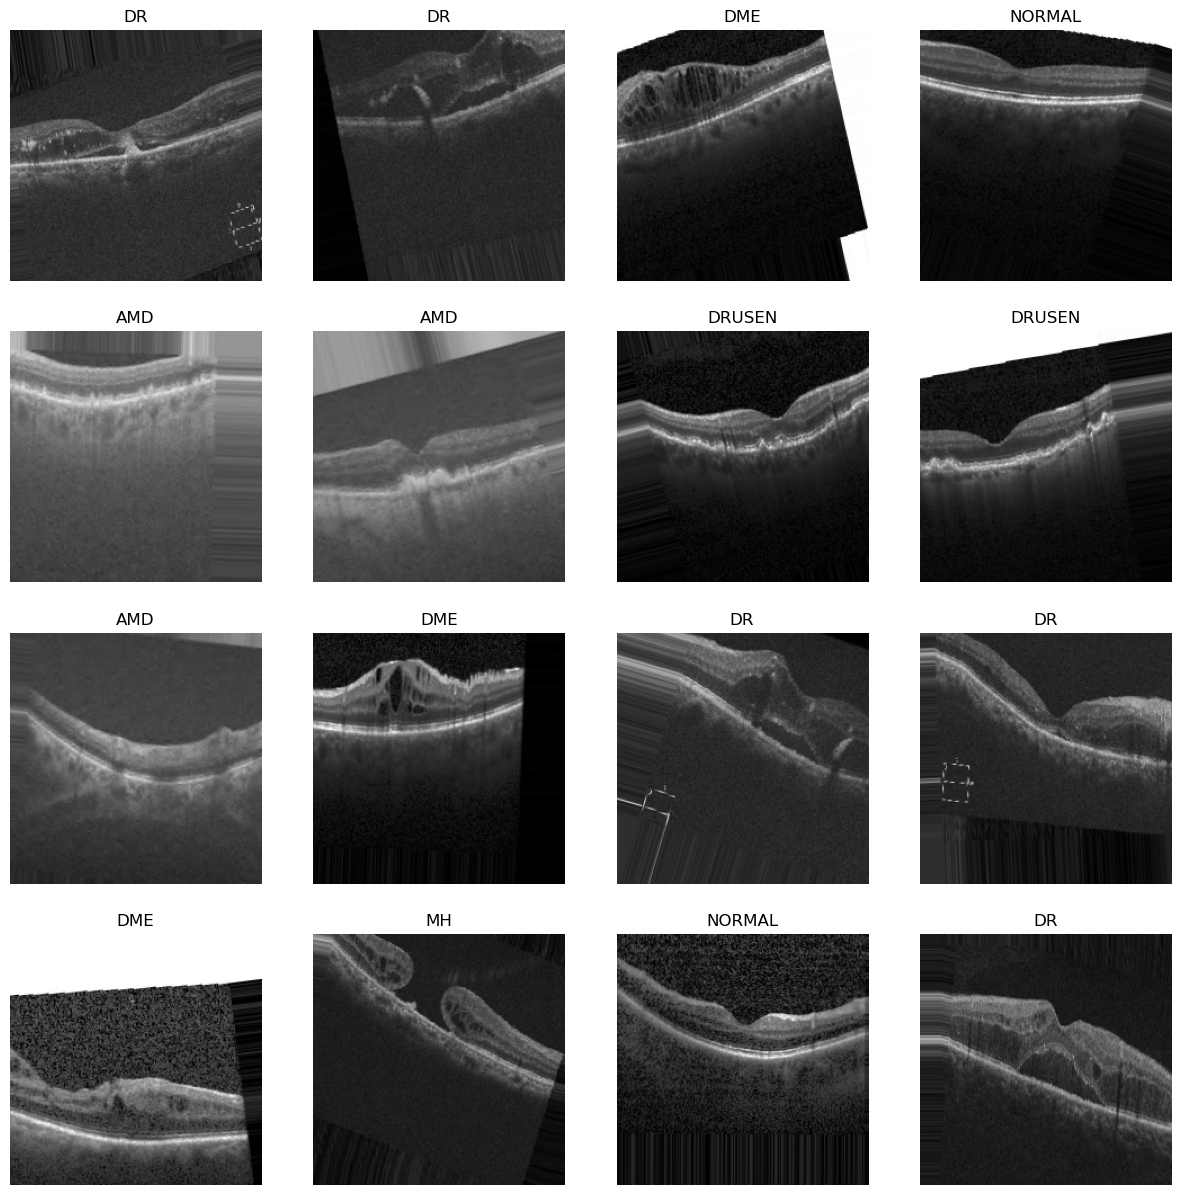

In [6]:
images,labels = next(train_data)
plt.figure(figsize=(15,15))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i])
    plt.title(Labels[np.argmax(labels[i])])
    plt.axis('off')
plt.show()

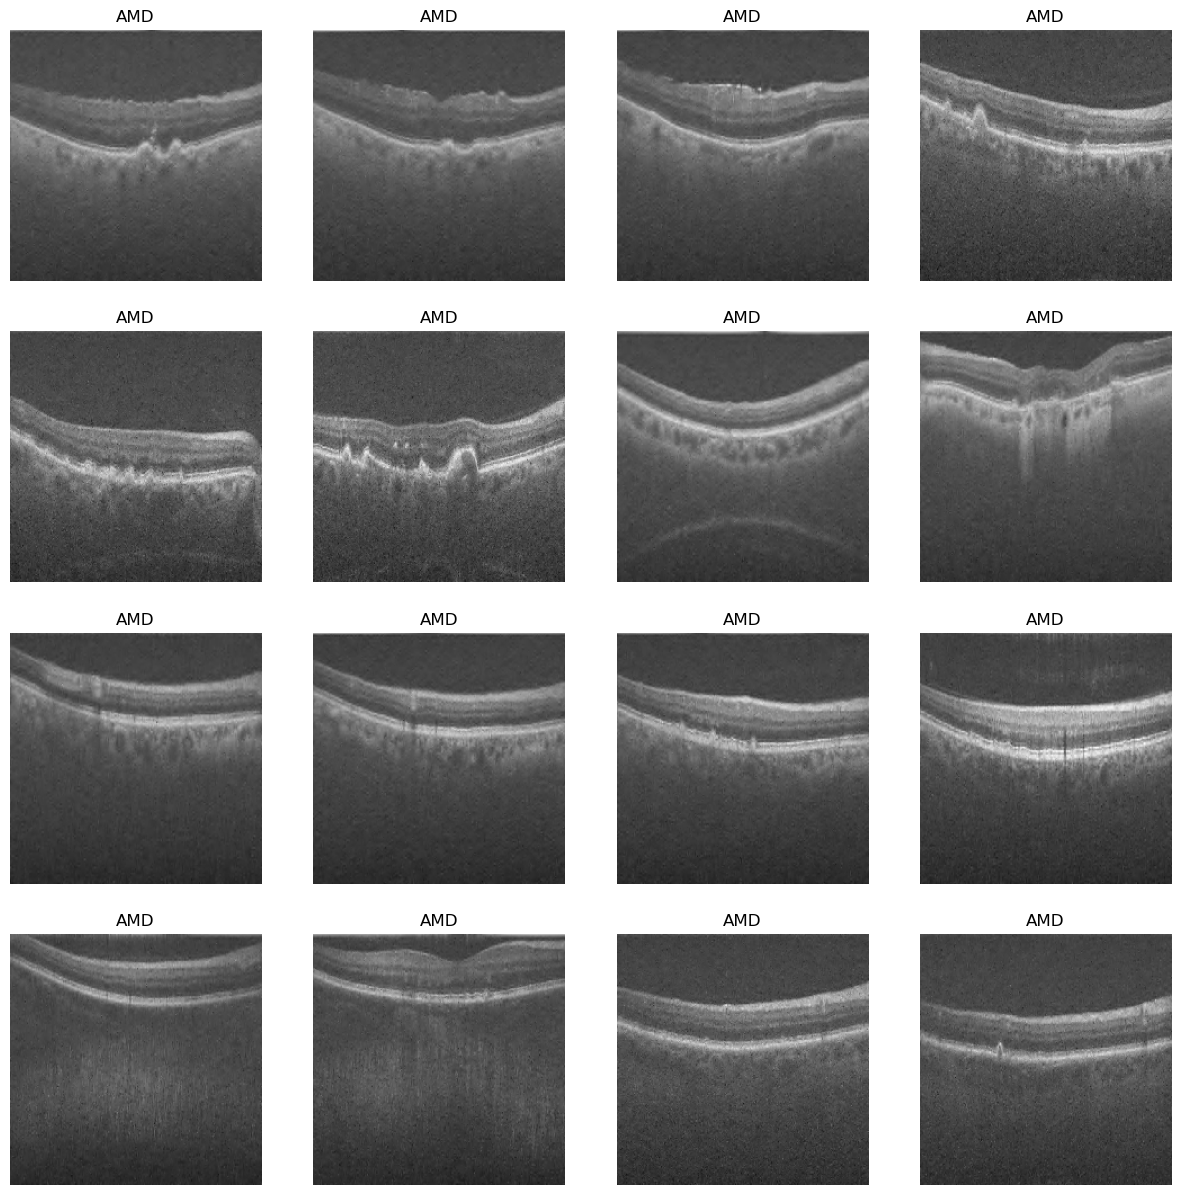

In [7]:
images,labels = next(val_data)
plt.figure(figsize=(15,15))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i])
    plt.title(Labels[np.argmax(labels[i])])
    plt.axis('off')
plt.show()

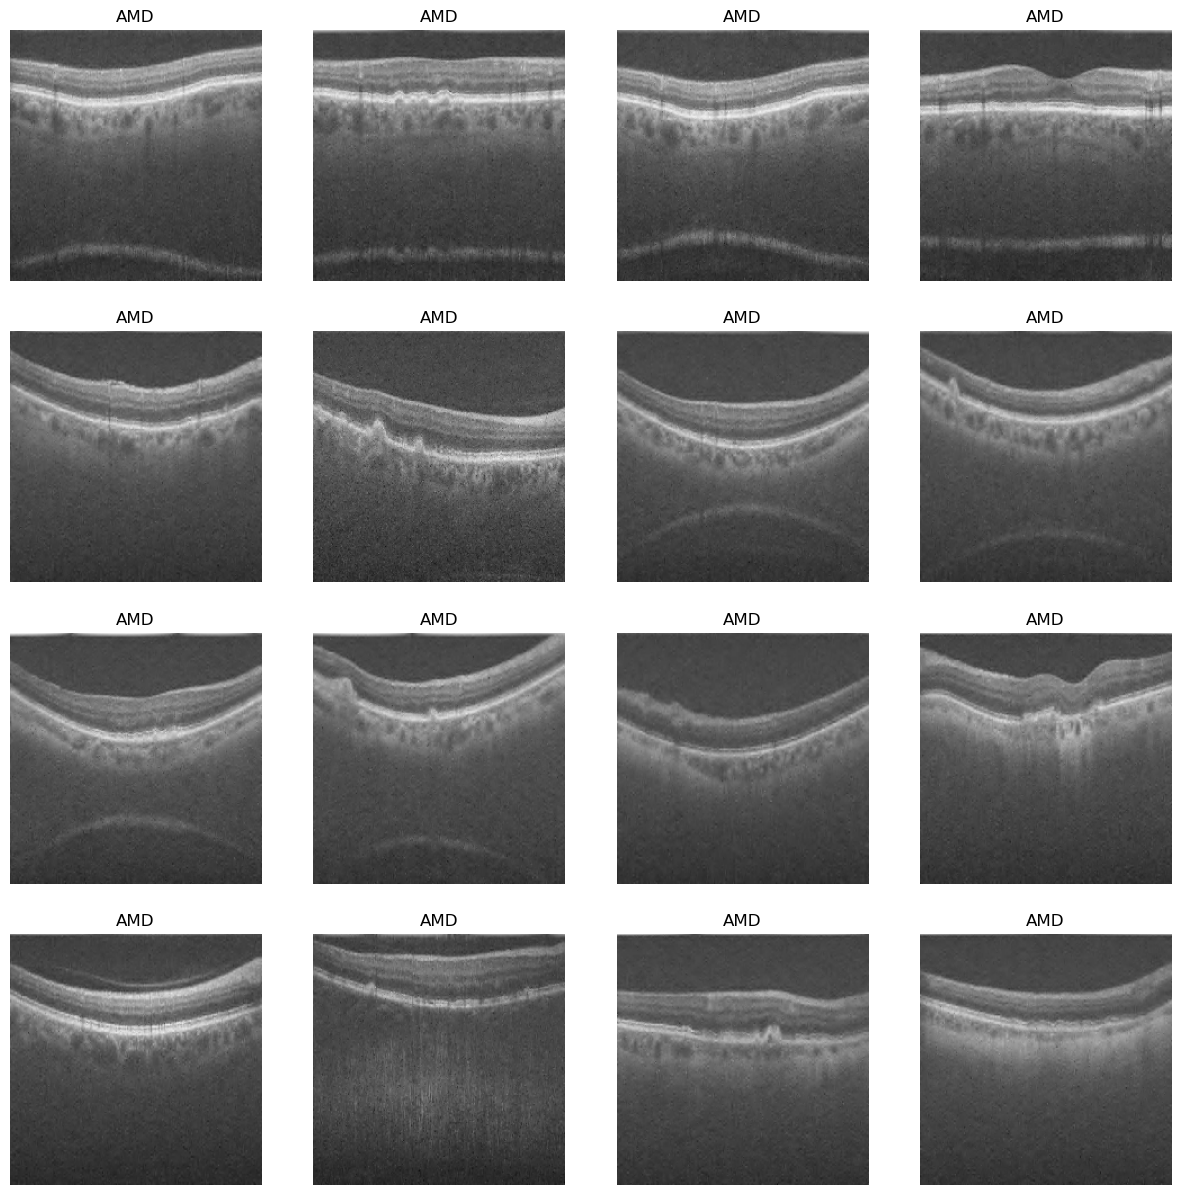

In [8]:
images,labels = next(test_data)
plt.figure(figsize=(15,15))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i])
    plt.title(Labels[np.argmax(labels[i])])
    plt.axis('off')
plt.show()

# Applying ResNet50 and ResNet101

In [9]:
from tensorflow.keras.applications.resnet import ResNet50
base_model = ResNet50(weights='imagenet', include_top = False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8,activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24,640,904
Trainable params: 1,053,192
Non-trainable params: 23,587,712
____________________________________

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',patience=5,restore_best_weights=True)

In [12]:
%load_ext tensorboard

In [13]:
import datetime
def create_tensorboard_callback():
    logdir = os.path.join('data/logs',datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
    return tf.keras.callbacks.TensorBoard(logdir)

In [14]:
tensorboard = create_tensorboard_callback()

In [15]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy']
             )

In [ ]:
Epochs = 25
history = model.fit(train_data, epochs=Epochs, validation_data=val_data, verbose=2,callbacks=[early_stopping])

Epoch 1/25
575/575 - 253s - loss: 2.0469 - accuracy: 0.1652 - val_loss: 1.9457 - val_accuracy: 0.2821 - 253s/epoch - 441ms/step
Epoch 2/25
575/575 - 204s - loss: 1.9185 - accuracy: 0.2288 - val_loss: 1.8514 - val_accuracy: 0.3525 - 204s/epoch - 354ms/step
Epoch 3/25
575/575 - 201s - loss: 1.8504 - accuracy: 0.2618 - val_loss: 1.7806 - val_accuracy: 0.3393 - 201s/epoch - 349ms/step
Epoch 4/25
575/575 - 200s - loss: 1.8035 - accuracy: 0.2920 - val_loss: 1.7244 - val_accuracy: 0.3643 - 200s/epoch - 347ms/step
Epoch 5/25
575/575 - 199s - loss: 1.7688 - accuracy: 0.2992 - val_loss: 1.6950 - val_accuracy: 0.3054 - 199s/epoch - 346ms/step
Epoch 6/25
575/575 - 200s - loss: 1.7307 - accuracy: 0.3211 - val_loss: 1.6310 - val_accuracy: 0.3539 - 200s/epoch - 348ms/step
Epoch 7/25
575/575 - 206s - loss: 1.7110 - accuracy: 0.3234 - val_loss: 1.6386 - val_accuracy: 0.3836 - 206s/epoch - 357ms/step
Epoch 8/25
575/575 - 205s - loss: 1.6846 - accuracy: 0.3313 - val_loss: 1.5948 - val_accuracy: 0.3871 - 

In [26]:
def plot_learning_curves(history):
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label = 'Training Accuracy')
    plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label = 'Training Loss')
    plt.plot(history.history['val_loss'],label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

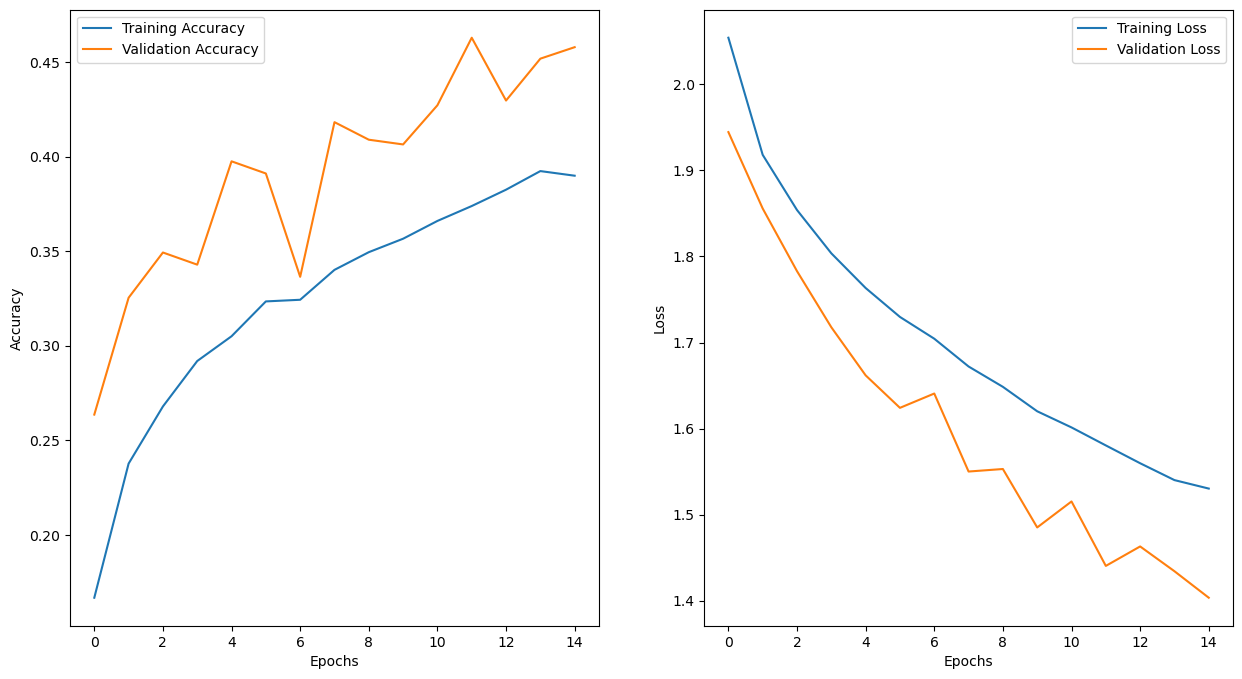

In [27]:
plot_learning_curves(history)

In [28]:
model.evaluate(test_data)

88/88 [==============================] - 15s 168ms/step - loss: 1.4367 - accuracy: 0.4650


[1.436673879623413, 0.4650000035762787]

# Let's try ResNet101

In [29]:
from tensorflow.keras.applications.resnet import ResNet101
base_model2 = ResNet101(weights='imagenet', include_top = False, input_shape=(224,224,3))
for layer in base_model2.layers:
    layer.trainable = False
base_model2.summary()

171446536/171446536 [==============================] - 27s 0us/step
Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                      

In [30]:
model2 = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    base_model2,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8,activation='softmax')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 8)                 8200      
                                                                 
Total params: 44,764,552
Trainable params: 2,106,376
Non-trainable params: 42,658,176
__________________________________

In [31]:
import datetime
def create_tensorboard_callback():
    logdir = os.path.join('data/logs/oct/resnet101',datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
    return tf.keras.callbacks.TensorBoard(logdir)
tensorboard = create_tensorboard_callback()

In [32]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.00003)
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy']
             )

In [33]:
Epochs = 50
history2 = model2.fit(train_data, epochs=Epochs, validation_data=val_data, verbose=2,callbacks=[early_stopping,tensorboard])

Epoch 1/50
575/575 - 162s - loss: 2.0689 - accuracy: 0.1587 - val_loss: 1.9899 - val_accuracy: 0.2436 - 162s/epoch - 282ms/step
Epoch 2/50
575/575 - 160s - loss: 1.9852 - accuracy: 0.1958 - val_loss: 1.9253 - val_accuracy: 0.2968 - 160s/epoch - 278ms/step
Epoch 3/50
575/575 - 160s - loss: 1.9343 - accuracy: 0.2140 - val_loss: 1.8941 - val_accuracy: 0.2757 - 160s/epoch - 278ms/step
Epoch 4/50
575/575 - 159s - loss: 1.9040 - accuracy: 0.2293 - val_loss: 1.8552 - val_accuracy: 0.2804 - 159s/epoch - 276ms/step
Epoch 5/50
575/575 - 160s - loss: 1.8779 - accuracy: 0.2439 - val_loss: 1.8323 - val_accuracy: 0.2911 - 160s/epoch - 279ms/step


In [34]:
%load_ext tensorboard
%tensorboard --logdir data/logs/oct/resnet101

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# ResNet101 with unfreezing last 8 layers


In [35]:
from tensorflow.keras.applications.resnet import ResNet101
base_model3 = ResNet101(weights='imagenet', include_top = False, input_shape=(224,224,3))
for layer in base_model3.layers[:-8]:
    layer.trainable = False
base_model3.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [36]:
model3 = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    base_model3,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8,activation='softmax')
])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 8)                 8200      
                                                                 
Total params: 44,764,552
Trainable params: 5,521,928
Non-trainable params: 39,242,624
__________________________________

In [37]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.00003)
model3.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy']
             )

In [39]:
Epochs = 50
history3 = model3.fit(train_data, epochs=Epochs, validation_data=val_data, verbose=2,callbacks=[early_stopping,tensorboard])

Epoch 1/50
575/575 - 163s - loss: 1.7129 - accuracy: 0.3096 - val_loss: 1.3717 - val_accuracy: 0.4364 - 163s/epoch - 284ms/step
Epoch 2/50
575/575 - 159s - loss: 1.3677 - accuracy: 0.4373 - val_loss: 1.6289 - val_accuracy: 0.3711 - 159s/epoch - 276ms/step
Epoch 3/50
575/575 - 157s - loss: 1.2305 - accuracy: 0.4865 - val_loss: 1.3258 - val_accuracy: 0.4839 - 157s/epoch - 273ms/step
Epoch 4/50
575/575 - 158s - loss: 1.1658 - accuracy: 0.5103 - val_loss: 0.9805 - val_accuracy: 0.5825 - 158s/epoch - 275ms/step
Epoch 5/50
575/575 - 157s - loss: 1.1106 - accuracy: 0.5297 - val_loss: 1.3875 - val_accuracy: 0.4918 - 157s/epoch - 274ms/step
Epoch 6/50
575/575 - 157s - loss: 1.0696 - accuracy: 0.5461 - val_loss: 2.4873 - val_accuracy: 0.2704 - 157s/epoch - 274ms/step
Epoch 7/50
575/575 - 157s - loss: 1.0352 - accuracy: 0.5646 - val_loss: 0.9911 - val_accuracy: 0.6007 - 157s/epoch - 273ms/step
Epoch 8/50
575/575 - 157s - loss: 1.0142 - accuracy: 0.5770 - val_loss: 1.0156 - val_accuracy: 0.5914 - 

In [40]:
%tensorboard --logdir data/logs/oct/resnet101

Reusing TensorBoard on port 6006 (pid 6084), started 1:53:31 ago. (Use '!kill 6084' to kill it.)

# Applying DensNet

In [18]:
from tensorflow.keras.applications import DenseNet201
dens_base = DenseNet201(weights='imagenet', include_top = False, input_shape=(224,224,3))
for layer in dens_base.layers:
    layer.trainable = False
dens_base.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [22]:
from tensorflow.keras import layers
dens_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    dens_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(8,activation='softmax')
])
dens_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_1   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1024)              1967104   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 8)                 8200      
                                                                 
Total params: 20,297,288
Trainable params: 1,975,304
Non-trainable params: 18,321,984
__________________________________

In [23]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)
dens_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy']
             )

In [24]:
Epochs = 50
dens_hist = dens_model.fit(train_data,epochs=Epochs, validation_data=val_data, verbose=2, callbacks=[early_stopping,tensorboard])


Epoch 1/50
575/575 - 241s - loss: 0.8760 - accuracy: 0.6895 - val_loss: 0.5147 - val_accuracy: 0.8114 - 241s/epoch - 420ms/step
Epoch 2/50
575/575 - 209s - loss: 0.5348 - accuracy: 0.8053 - val_loss: 0.4278 - val_accuracy: 0.8443 - 209s/epoch - 363ms/step
Epoch 3/50
575/575 - 202s - loss: 0.4555 - accuracy: 0.8355 - val_loss: 0.3771 - val_accuracy: 0.8632 - 202s/epoch - 351ms/step
Epoch 4/50
575/575 - 208s - loss: 0.4172 - accuracy: 0.8480 - val_loss: 0.3498 - val_accuracy: 0.8721 - 208s/epoch - 362ms/step
Epoch 5/50
575/575 - 204s - loss: 0.3938 - accuracy: 0.8545 - val_loss: 0.3507 - val_accuracy: 0.8689 - 204s/epoch - 355ms/step
Epoch 6/50
575/575 - 204s - loss: 0.3744 - accuracy: 0.8612 - val_loss: 0.3214 - val_accuracy: 0.8804 - 204s/epoch - 355ms/step
Epoch 7/50
575/575 - 206s - loss: 0.3584 - accuracy: 0.8671 - val_loss: 0.3454 - val_accuracy: 0.8739 - 206s/epoch - 359ms/step
Epoch 8/50
575/575 - 197s - loss: 0.3434 - accuracy: 0.8683 - val_loss: 0.3090 - val_accuracy: 0.8868 - 

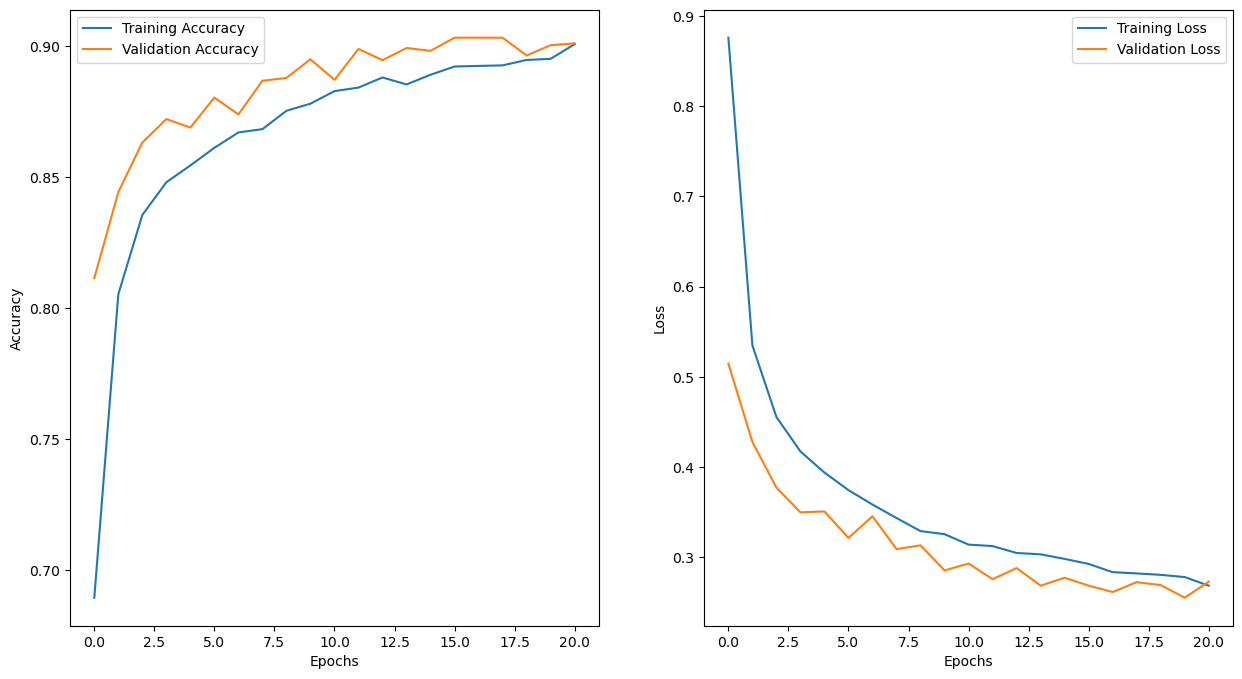

In [27]:
plot_learning_curves(dens_hist)

In [28]:
dens_model.evaluate(test_data)

88/88 [==============================] - 16s 181ms/step - loss: 0.2786 - accuracy: 0.8957


[0.27859222888946533, 0.895714282989502]

# DensNet with 7 unfreezing layers

In [32]:
from tensorflow.keras.applications import DenseNet201
dens_base2 = DenseNet201(weights='imagenet', include_top = False, input_shape=(224,224,3))
for layer in dens_base2.layers[:-14]:
    # print(layer.name)
    layer.trainable = False
dens_base2.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_8 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_7[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_8[0][0]']       
                                )                                                       

In [33]:
from tensorflow.keras import layers
dens_model2 = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    dens_base2,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(8,activation='softmax')
])
dens_model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_2   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1024)              1967104   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 8)                 8200      
                                                                 
Total params: 20,297,288
Trainable params: 2,536,392
Non-trainable params: 17,760,896
__________________________________

In [34]:
dens_model2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy']
             )

In [35]:
Epochs = 50
dens_hist2 = dens_model2.fit(train_data,epochs=Epochs, validation_data=val_data, verbose=2, callbacks=[early_stopping])

Epoch 1/50
575/575 - 224s - loss: 0.4565 - accuracy: 0.8303 - val_loss: 0.2193 - val_accuracy: 0.9243 - 224s/epoch - 390ms/step
Epoch 2/50
575/575 - 221s - loss: 0.2423 - accuracy: 0.9130 - val_loss: 0.1926 - val_accuracy: 0.9314 - 221s/epoch - 385ms/step
Epoch 3/50
575/575 - 219s - loss: 0.2000 - accuracy: 0.9283 - val_loss: 0.1686 - val_accuracy: 0.9407 - 219s/epoch - 381ms/step
Epoch 4/50
575/575 - 217s - loss: 0.1765 - accuracy: 0.9362 - val_loss: 0.2003 - val_accuracy: 0.9314 - 217s/epoch - 377ms/step
Epoch 5/50
575/575 - 220s - loss: 0.1731 - accuracy: 0.9396 - val_loss: 0.1594 - val_accuracy: 0.9414 - 220s/epoch - 383ms/step
Epoch 6/50
575/575 - 221s - loss: 0.1582 - accuracy: 0.9418 - val_loss: 0.1503 - val_accuracy: 0.9489 - 221s/epoch - 384ms/step
Epoch 7/50
575/575 - 169s - loss: 0.1494 - accuracy: 0.9485 - val_loss: 0.1804 - val_accuracy: 0.9375 - 169s/epoch - 295ms/step
Epoch 8/50
575/575 - 159s - loss: 0.1438 - accuracy: 0.9497 - val_loss: 0.1525 - val_accuracy: 0.9479 - 

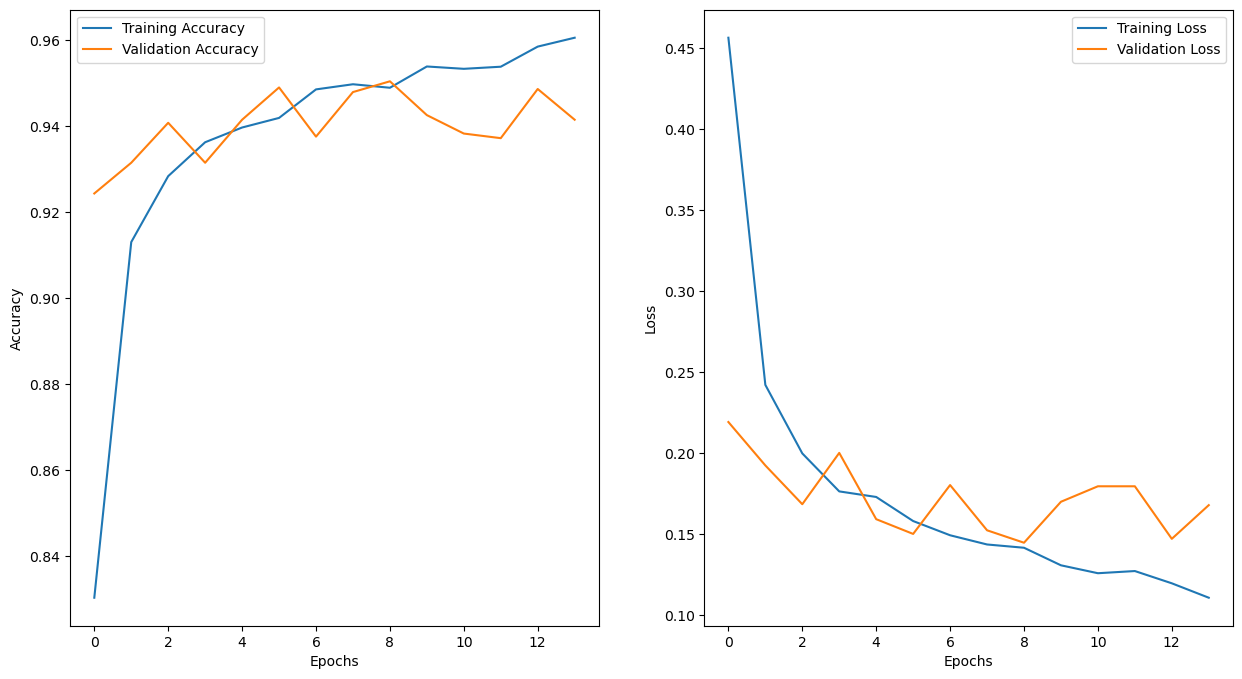

In [36]:
plot_learning_curves(dens_hist2)

In [37]:
dens_model2.evaluate(test_data)

88/88 [==============================] - 12s 133ms/step - loss: 0.1556 - accuracy: 0.9446


[0.155591681599617, 0.9446428418159485]

In [44]:
from tensorflow.keras.applications import DenseNet201
dens_base3 = DenseNet201(weights='imagenet', include_top = False, input_shape=(224,224,3))
#i=1
for layer in dens_base3.layers[:-42]:
    # print(i,end=' ')
    # i=i+1
    # print(layer.name)
    layer.trainable = False
dens_base3.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_20 (ZeroPadding  (None, 230, 230, 3)  0          ['input_14[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_20[0][0]']      
                                )                                                       

In [45]:
from tensorflow.keras import layers
dens_model3 = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    dens_base3,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(8,activation='softmax')
])
dens_model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_3   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 1024)              1967104   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 8)                 8200      
                                                                 
Total params: 20,297,288
Trainable params: 3,608,648
Non-trainable params: 16,688,640
__________________________________

In [47]:
dens_model3.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy']
             )

In [48]:
import datetime
def create_tensorboard_callback():
    logdir = os.path.join('data/logs/oct/densnet201',datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
    return tf.keras.callbacks.TensorBoard(logdir)
tensorboard = create_tensorboard_callback()

In [49]:
Epochs = 50
dens_hist3 = dens_model3.fit(train_data,epochs=Epochs, validation_data=val_data, verbose=2, callbacks=[early_stopping,tensorboard])

Epoch 1/50
575/575 - 229s - loss: 0.3988 - accuracy: 0.8565 - val_loss: 0.1929 - val_accuracy: 0.9336 - 229s/epoch - 399ms/step
Epoch 2/50
575/575 - 203s - loss: 0.2071 - accuracy: 0.9264 - val_loss: 0.2380 - val_accuracy: 0.9157 - 203s/epoch - 353ms/step
Epoch 3/50
575/575 - 211s - loss: 0.1806 - accuracy: 0.9355 - val_loss: 0.1690 - val_accuracy: 0.9386 - 211s/epoch - 367ms/step
Epoch 4/50
575/575 - 219s - loss: 0.1639 - accuracy: 0.9426 - val_loss: 0.1492 - val_accuracy: 0.9461 - 219s/epoch - 380ms/step
Epoch 5/50
575/575 - 206s - loss: 0.1497 - accuracy: 0.9467 - val_loss: 0.1880 - val_accuracy: 0.9386 - 206s/epoch - 358ms/step
Epoch 6/50
575/575 - 202s - loss: 0.1442 - accuracy: 0.9482 - val_loss: 0.1762 - val_accuracy: 0.9400 - 202s/epoch - 351ms/step
Epoch 7/50
575/575 - 208s - loss: 0.1319 - accuracy: 0.9514 - val_loss: 0.1680 - val_accuracy: 0.9450 - 208s/epoch - 361ms/step
Epoch 8/50
575/575 - 206s - loss: 0.1249 - accuracy: 0.9553 - val_loss: 0.1559 - val_accuracy: 0.9464 - 

In [50]:
%tensorboard --logdir data/logs/oct/densnet201

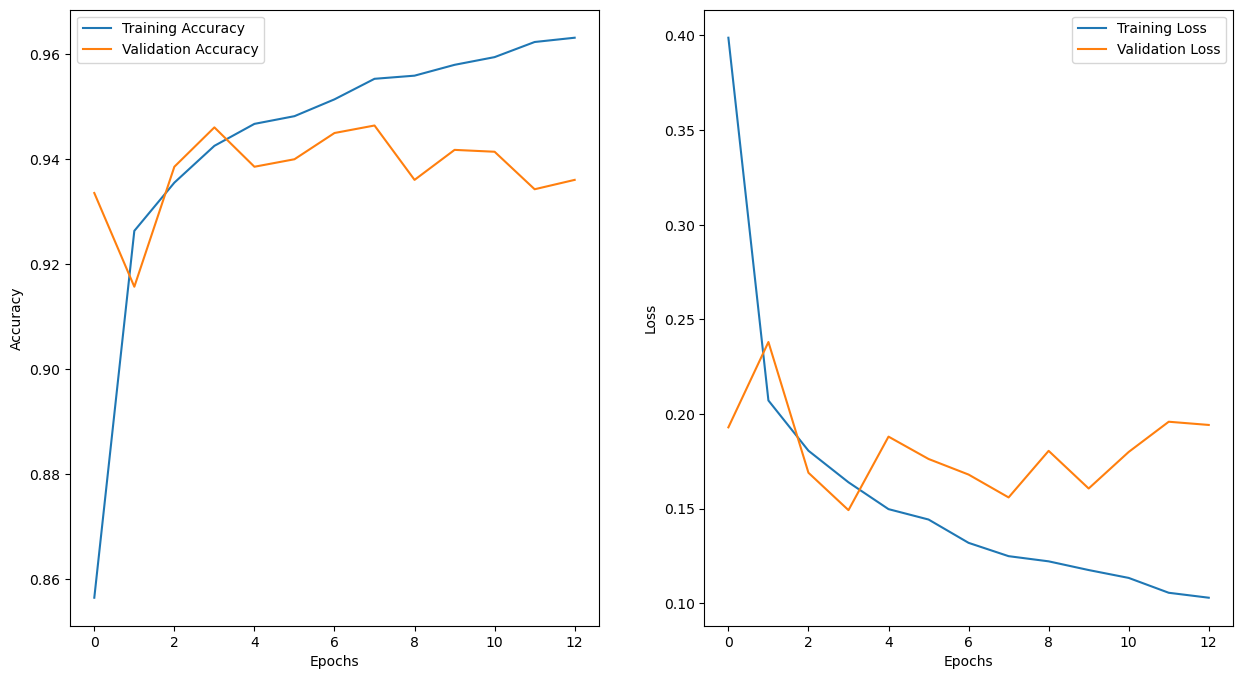

In [51]:
plot_learning_curves(dens_hist3)

In [52]:
dens_model3.evaluate(test_data)

88/88 [==============================] - 12s 135ms/step - loss: 0.1717 - accuracy: 0.9446


[0.1717471033334732, 0.9446428418159485]

In [58]:
from tensorflow.keras.applications import DenseNet201
dens_base4 = DenseNet201(weights='imagenet', include_top = False, input_shape=(224,224,3))
#i=1
for layer in dens_base4.layers[:-224]:
    # print(i,end=' ')
    # i=i+1
    # print(layer.name)
    layer.trainable = False
dens_base4.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_30 (ZeroPadding  (None, 230, 230, 3)  0          ['input_20[0][0]']               
 2D)                                                                                              
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_30[0][0]']      
                                )                                                       

In [59]:
from tensorflow.keras import layers
dens_model4 = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    dens_base4,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(8,activation='softmax')
])
dens_model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_4   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 1024)              1967104   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_9 (Dense)             (None, 8)                 8200      
                                                                 
Total params: 20,297,288
Trainable params: 8,955,912
Non-trainable params: 11,341,376
__________________________________

In [60]:
dens_model4.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy']
             )

In [61]:
Epochs = 50
dens_hist4 = dens_model4.fit(train_data,epochs=Epochs, validation_data=val_data, verbose=2, callbacks=[early_stopping])

Epoch 1/50
575/575 - 221s - loss: 0.3260 - accuracy: 0.8829 - val_loss: 0.1637 - val_accuracy: 0.9425 - 221s/epoch - 385ms/step
Epoch 2/50
575/575 - 185s - loss: 0.1810 - accuracy: 0.9347 - val_loss: 0.1547 - val_accuracy: 0.9446 - 185s/epoch - 322ms/step
Epoch 3/50
575/575 - 164s - loss: 0.1546 - accuracy: 0.9440 - val_loss: 0.1476 - val_accuracy: 0.9525 - 164s/epoch - 284ms/step
Epoch 4/50
575/575 - 164s - loss: 0.1336 - accuracy: 0.9520 - val_loss: 0.1390 - val_accuracy: 0.9486 - 164s/epoch - 285ms/step
Epoch 5/50
575/575 - 164s - loss: 0.1225 - accuracy: 0.9572 - val_loss: 0.1475 - val_accuracy: 0.9479 - 164s/epoch - 285ms/step
Epoch 6/50
575/575 - 164s - loss: 0.1179 - accuracy: 0.9598 - val_loss: 0.1413 - val_accuracy: 0.9554 - 164s/epoch - 286ms/step
Epoch 7/50
575/575 - 163s - loss: 0.1119 - accuracy: 0.9592 - val_loss: 0.1346 - val_accuracy: 0.9546 - 163s/epoch - 284ms/step
Epoch 8/50
575/575 - 164s - loss: 0.0993 - accuracy: 0.9653 - val_loss: 0.1806 - val_accuracy: 0.9450 - 

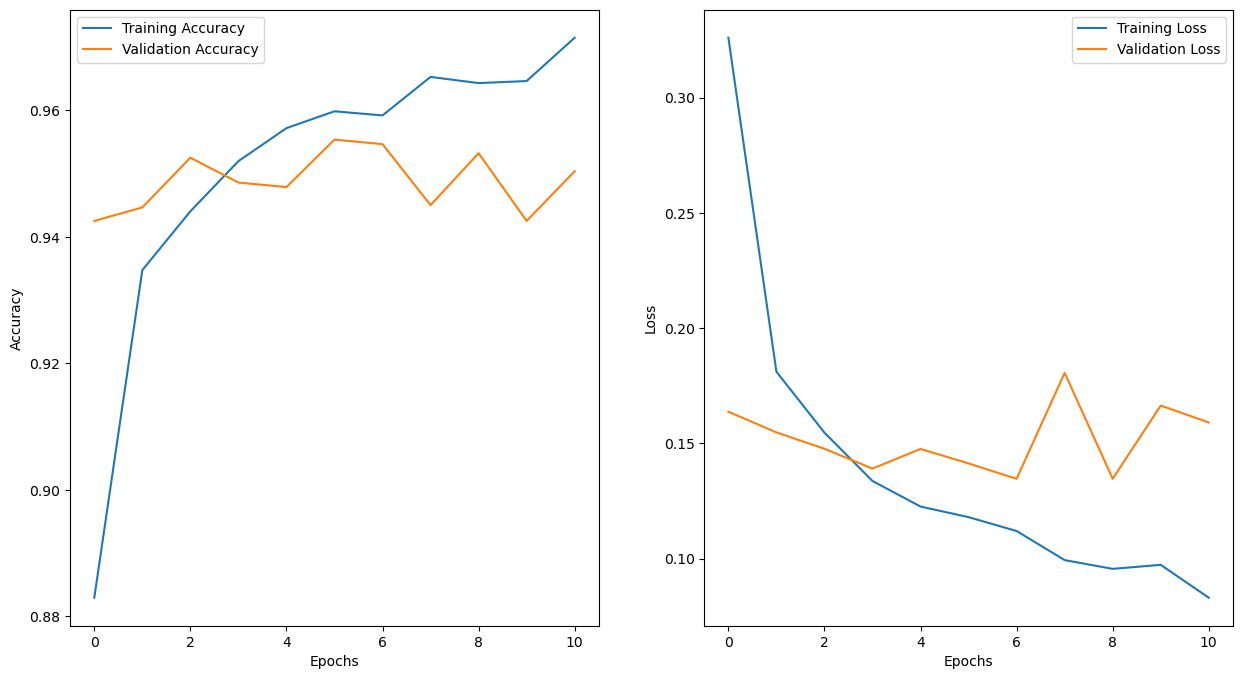

In [62]:
plot_learning_curves(dens_hist4)

In [63]:
dens_model4.evaluate(test_data)

88/88 [==============================] - 12s 130ms/step - loss: 0.1487 - accuracy: 0.9525


[0.14874297380447388, 0.9524999856948853]

In [64]:
dens_model5 = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    dens_base2,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(8,activation='softmax')
])
dens_model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_5   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 1024)              1967104   
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_11 (Dense)            (None, 256)               262400    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                      

In [65]:
optimizer = Adam(learning_rate=0.00001)
dens_model5.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy']
             )

In [66]:
Epochs = 50
dens_hist5 = dens_model5.fit(train_data,epochs=Epochs, validation_data=val_data, verbose=2, callbacks=[early_stopping])

Epoch 1/50
575/575 - 170s - loss: 1.5449 - accuracy: 0.4354 - val_loss: 0.8328 - val_accuracy: 0.7539 - 170s/epoch - 296ms/step
Epoch 2/50
575/575 - 164s - loss: 0.8402 - accuracy: 0.7007 - val_loss: 0.4871 - val_accuracy: 0.8343 - 164s/epoch - 286ms/step
Epoch 3/50
575/575 - 163s - loss: 0.5906 - accuracy: 0.7898 - val_loss: 0.3681 - val_accuracy: 0.8675 - 163s/epoch - 284ms/step
Epoch 4/50
575/575 - 164s - loss: 0.4700 - accuracy: 0.8305 - val_loss: 0.3099 - val_accuracy: 0.8907 - 164s/epoch - 285ms/step
Epoch 5/50
575/575 - 165s - loss: 0.4071 - accuracy: 0.8533 - val_loss: 0.2730 - val_accuracy: 0.9061 - 165s/epoch - 286ms/step
Epoch 6/50
575/575 - 173s - loss: 0.3576 - accuracy: 0.8715 - val_loss: 0.2481 - val_accuracy: 0.9154 - 173s/epoch - 300ms/step
Epoch 7/50
575/575 - 174s - loss: 0.3316 - accuracy: 0.8797 - val_loss: 0.2271 - val_accuracy: 0.9214 - 174s/epoch - 303ms/step
Epoch 8/50
575/575 - 175s - loss: 0.2906 - accuracy: 0.8959 - val_loss: 0.2223 - val_accuracy: 0.9211 - 

In [68]:
dens_model5.save('models/DR/oct_densnet201_7_unfreezing_layer.h5')

In [69]:
dens_model5.evaluate(test_data)

88/88 [==============================] - 11s 127ms/step - loss: 0.1672 - accuracy: 0.9439


[0.16719619929790497, 0.943928599357605]

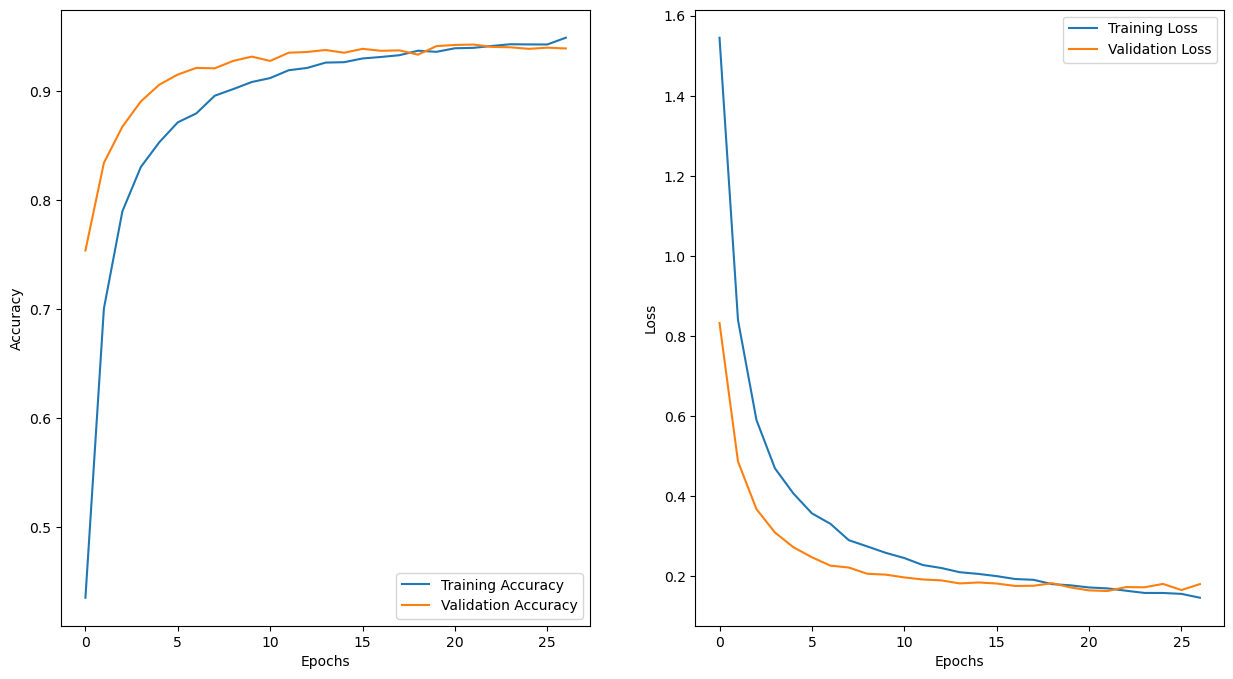

In [70]:
plot_learning_curves(dens_hist5)